<a href="https://colab.research.google.com/github/iamprakashom/NLP-with-Deep-Learning/blob/master/Transfer_Learning_using_ULMFit_for_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install required library: -q flag with pip is for slient installation
!pip install -q torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install -q fastai

     |████████████████████████████████| 576.2MB 27kB/s 


In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
# Import 20 newsgroup dataset
from sklearn.datasets import fetch_20newsgroups

In [4]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('header', 'footers', 'quotes'))

In [5]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
dataset.target

array([17,  0, 17, 11, ..., 13,  9,  4,  9])

In [7]:
dataset.data[:5]

['From: ab4z@Virginia.EDU ("Andi Beyer")\nSubject: Re: Israeli Terrorism\nOrganization: University of Virginia\nLines: 15',
 "From: timmbake@mcl.ucsb.edu (Bake Timmons)\nSubject: Re: Amusing atheists and agnostics\nLines: 66\n\n\n\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap of faith, Jimmy.  Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n\nSorry I can't pity you, Jim.  And I'm sorry that you have these feelings of\ndenial about the faith you need to get by.  Oh well, just pretend that it will\nall end happily ever after anyway.  Maybe if you start a new newsgroup,\nalt.atheist.hard, you won't be bummin' so much?\n\n\n\n\n\n\nBye-Bye, Big Jim.  Don't forget your Flintstone's Chewables!  :) \n--\nBake Timmons, III",
 "From: bc744@cleveland.Freenet.Edu (Mark Ira Kaufman)\nSubject: Re: rejoinder. Questions to Israelis\nOrganization: Case Western Reserve University, Cleveland, Ohio (USA)\nLines: 38\nNNTP-P

In [0]:
#Let’s create a dataframe consisting of the text documents and their corresponding labels (newsgroup names).
df = pd.DataFrame({'label': dataset.target, 'text': dataset.data})

In [9]:
df.head()

,label,text
0,17,"From: ab4z@Virginia.EDU (""Andi Beyer"")\nSubjec..."
1,0,From: timmbake@mcl.ucsb.edu (Bake Timmons)\nSu...
2,17,From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...
3,11,From: ray@ole.cdac.com (Ray Berry)\nSubject: C...
4,10,From: kkeller@mail.sas.upenn.edu (Keith Keller...


In [10]:
df.shape

(11314, 2)

We’ll convert this into a binary classification problem by selecting only 2 out of the 20 labels present in the dataset. We will select labels 1 and 10 which correspond to **‘comp.graphics**’ and ‘**rec.sport.hockey**’, respectively.

In [0]:
df = df[df['label'].isin([1,10])]
df.reset_index(drop=True, inplace=True)

In [12]:
df.head()

,label,text
0,10,From: kkeller@mail.sas.upenn.edu (Keith Keller...
1,1,From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...
2,10,From: jwh@sei.cmu.edu (John Huber)\nSubject: R...
3,10,From: jimg@cybernet.cse.fau.edu (Jim Gorycki)\...
4,10,From: farenebt@craft.camp.clarkson.edu (Droopy...


In [13]:
df['label'].unique()

array([10,  1])

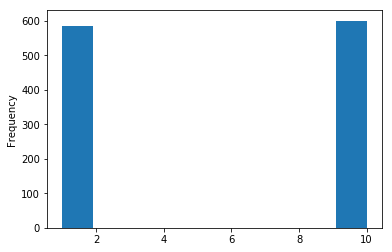

In [14]:
# class label distribution
df['label'].plot(kind='hist')

In [15]:
df['label'].value_counts()

10    600
1     584
Name: label, dtype: int64

Both classes have almost equal distribution.

**Data Preprocessing**

In [0]:
df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")

In [17]:
# remove stop words
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# tokenization and removing stopwords
tokenized_doc = df['text'].apply(lambda x: x.split())

detokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [0]:
df['text'] = df['text'].apply(lambda x: " ".join([item for item in x.split() if item not in stop_words]))

In [0]:
# tokenization 
tokenized_doc = df['text'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words]) 

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 
df['text'] = detokenized_doc

In [21]:
df.head()

,label,text
0,10,From kkeller mail sas upenn edu Keith Keller S...
1,1,From nfotis ntua gr Nick C Fotis Subject Apr C...
2,10,From jwh sei cmu edu John Huber Subject Re NHL...
3,10,From jimg cybernet cse fau edu Jim Gorycki Sub...
4,10,From farenebt craft camp clarkson edu Droopy S...


In [0]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, stratify=df['label'], test_size = 0.4, random_state=12)

In [23]:
print(df_train.shape, df_test.shape)

(710, 2) (474, 2)


**Data Preparation**

**Prepare data** in ULMFit language model format - using fastai library

In [0]:
# Language model data
data_lang_model = TextLMDataBunch.from_df(train_df = df_train, valid_df=df_test, path="")

In [25]:
data_lang_model

TextLMDataBunch;

Train: LabelList (710 items)
x: LMTextList
xxbos xxmaj from golchowy alchemy chem utoronto ca xxmaj gerald xxmaj olchowy xxmaj subject xxmaj re xxup wc xxmaj results xxmaj april xxmaj organization xxmaj university xxmaj toronto xxmaj chemistry xxmaj department xxmaj lines xxmaj it looks like xxmaj edmonton xxmaj oilers decided take xxmaj european xxunk spring xxmaj ranford xxmaj tugnutt xxmaj benning xxmaj manson xxmaj smith xxmaj buchberger xxmaj corson playing xxmaj canada xxmaj podein xxmaj weight playing xxup us xxmaj is xxmaj kravchuk playing xxmaj xxunk i know nagging injuries late season xxmaj podein interesting case eligible play xxmaj cape xxmaj breton xxup ahl playoffs like xxmaj kovalev xxmaj zubov xxmaj andersson obviously xxmaj sather xxmaj pocklington total xxunk everyone makes certainly case massively xxunk xxmaj paramount xxmaj new xxmaj york xxmaj rangers,xxbos xxmaj from andy bgsu edu xxmaj ryan xxmaj subject xxmaj what xxunk xxunk xxmaj my xxmaj pre

In [26]:
data_lang_model.train_ds

LabelList (710 items)
x: LMTextList
xxbos xxmaj from golchowy alchemy chem utoronto ca xxmaj gerald xxmaj olchowy xxmaj subject xxmaj re xxup wc xxmaj results xxmaj april xxmaj organization xxmaj university xxmaj toronto xxmaj chemistry xxmaj department xxmaj lines xxmaj it looks like xxmaj edmonton xxmaj oilers decided take xxmaj european xxunk spring xxmaj ranford xxmaj tugnutt xxmaj benning xxmaj manson xxmaj smith xxmaj buchberger xxmaj corson playing xxmaj canada xxmaj podein xxmaj weight playing xxup us xxmaj is xxmaj kravchuk playing xxmaj xxunk i know nagging injuries late season xxmaj podein interesting case eligible play xxmaj cape xxmaj breton xxup ahl playoffs like xxmaj kovalev xxmaj zubov xxmaj andersson obviously xxmaj sather xxmaj pocklington total xxunk everyone makes certainly case massively xxunk xxmaj paramount xxmaj new xxmaj york xxmaj rangers,xxbos xxmaj from andy bgsu edu xxmaj ryan xxmaj subject xxmaj what xxunk xxunk xxmaj my xxmaj predictions classic playoff 

In [27]:
data_lang_model.valid_ds

LabelList (474 items)
x: LMTextList
xxbos xxmaj from danny xxunk danny xxunk canrem com xxmaj subject radiosity xxmaj reply xxmaj to danny xxunk danny xxunk canrem com xxmaj organization xxmaj canada xxmaj remote xxmaj systems xxmaj distribution comp xxmaj lines i looking source code radiosity method i know kind machine want program xxmaj radiance comes c source code i ftp access i tell get via way,xxbos xxmaj from xxunk engr engr xxunk edu m xxmaj xxunk xxmaj xxunk xxmaj subject xxmaj xxunk imaging xxmaj summary xxmaj xxunk imaging xxmaj keywords xxunk xxmaj nntp xxmaj posting xxmaj host engr engr xxunk edu xxmaj organization xxmaj university xxmaj xxunk xxmaj lines i interested information xxunk imaging sun workstation xxmaj for part i need know hardware available interface system whether xxunk rates sufficient produce quality image xxunk xxmaj any information subject would greatly appreciated,xxbos xxmaj from v r g xxunk cc buffalo edu xxmaj we xxup not xxunk xxup xxunk xxup of xxup

In [0]:
# Classification data model
data_class = TextClasDataBunch.from_df(path="", train_df=df_train, valid_df = df_test, vocab=data_lang_model.train_ds.vocab, bs=32)

**Fine Tuning the pre-trained Model and Making prediction**

In [0]:
learner = language_model_learner(data_lang_model, arch=AWD_LSTM, pretrained=URLs.WT103, drop_mult=0.7)

In [30]:
# train the model with learning rate = 1e-2
learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.414643,5.186003,0.273847,00:12


In [31]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


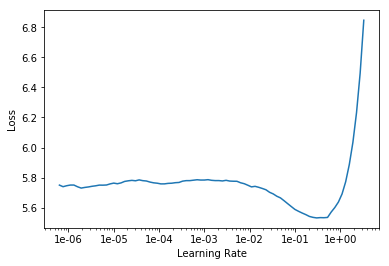

In [32]:
learner.recorder.plot()

In [0]:
#save this encoder to use it for classification later.
learner.save_encoder("ft_enc")

In [0]:
# using `data_class` object to build classifier with our fine-tuned encoder
learner = text_classifier_learner(data_class, arch=AWD_LSTM,drop_mult=0.7)
learner.load_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


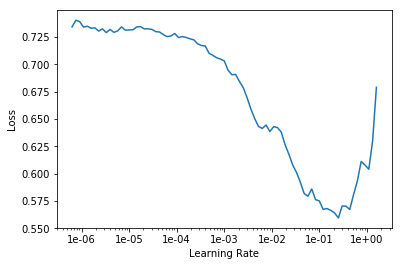

In [35]:
learner.lr_find()
learner.recorder.plot()

In [36]:
# again try fitting model
learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.500997,0.344537,0.837553,00:33


In [37]:
# again try fitting model with learning rate 1e-1
learner.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.427289,0.143897,0.936709,00:33
